# Tutorial 1: Set up

Throughout this tutorial, you will get familiar with:

* What are noisy labels?

* How to simulate noisy labels for controlled experiments?

## 1. What are noisy labels?

Throughout this tutorial, we use [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset for illustration.

**CIFAR-10 dataset**

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, including airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck. There are 50000 training images and 10000 test images, with 6000 images per class. 

### The definition of noisy labels

For a $K$-class classification task, we denote by $X\in \mathcal{X}$ a high-dimensional feature and $Y\in \mathcal{Y} :=\{1,2,...,K\}$ the corresponding label. Suppose $(X, Y)\in \mathcal{X} \times \mathcal{Y}$ are drawn from a joint distribution $\mathcal{D}$. 

The noisy label literature ([Natarajan et al., 2013](https://proceedings.neurips.cc/paper/5073-learning-with-noisy-labels.pdf); [Liu & Tao, 2015](https://arxiv.org/abs/1411.7718); [Patrini et al., 2017](https://openaccess.thecvf.com/content_cvpr_2017/papers/Patrini_Making_Deep_Neural_CVPR_2017_paper.pdf)) considers the setting where we only have access to samples with noisy labels from $(X, \widetilde{Y})$. Suppose random variables $(X, \widetilde{Y})\in \mathcal{X} \times \widetilde{\mathcal{Y}}$ are drawn from a noisy joint distribution $\mathcal{\widetilde{D}}$. 

The figure below illustrates an example of noisy labels -- human annotations, which may differ from the ground-truth labels. Specifiaclly, we visualize several CIFAR-10 images, along with the human annotation that we obtain from Amazon Mechanical Turk. One could view such human annotation as noisy labels since they are not always matching with the ground-truth labels (as shown in circled images). 

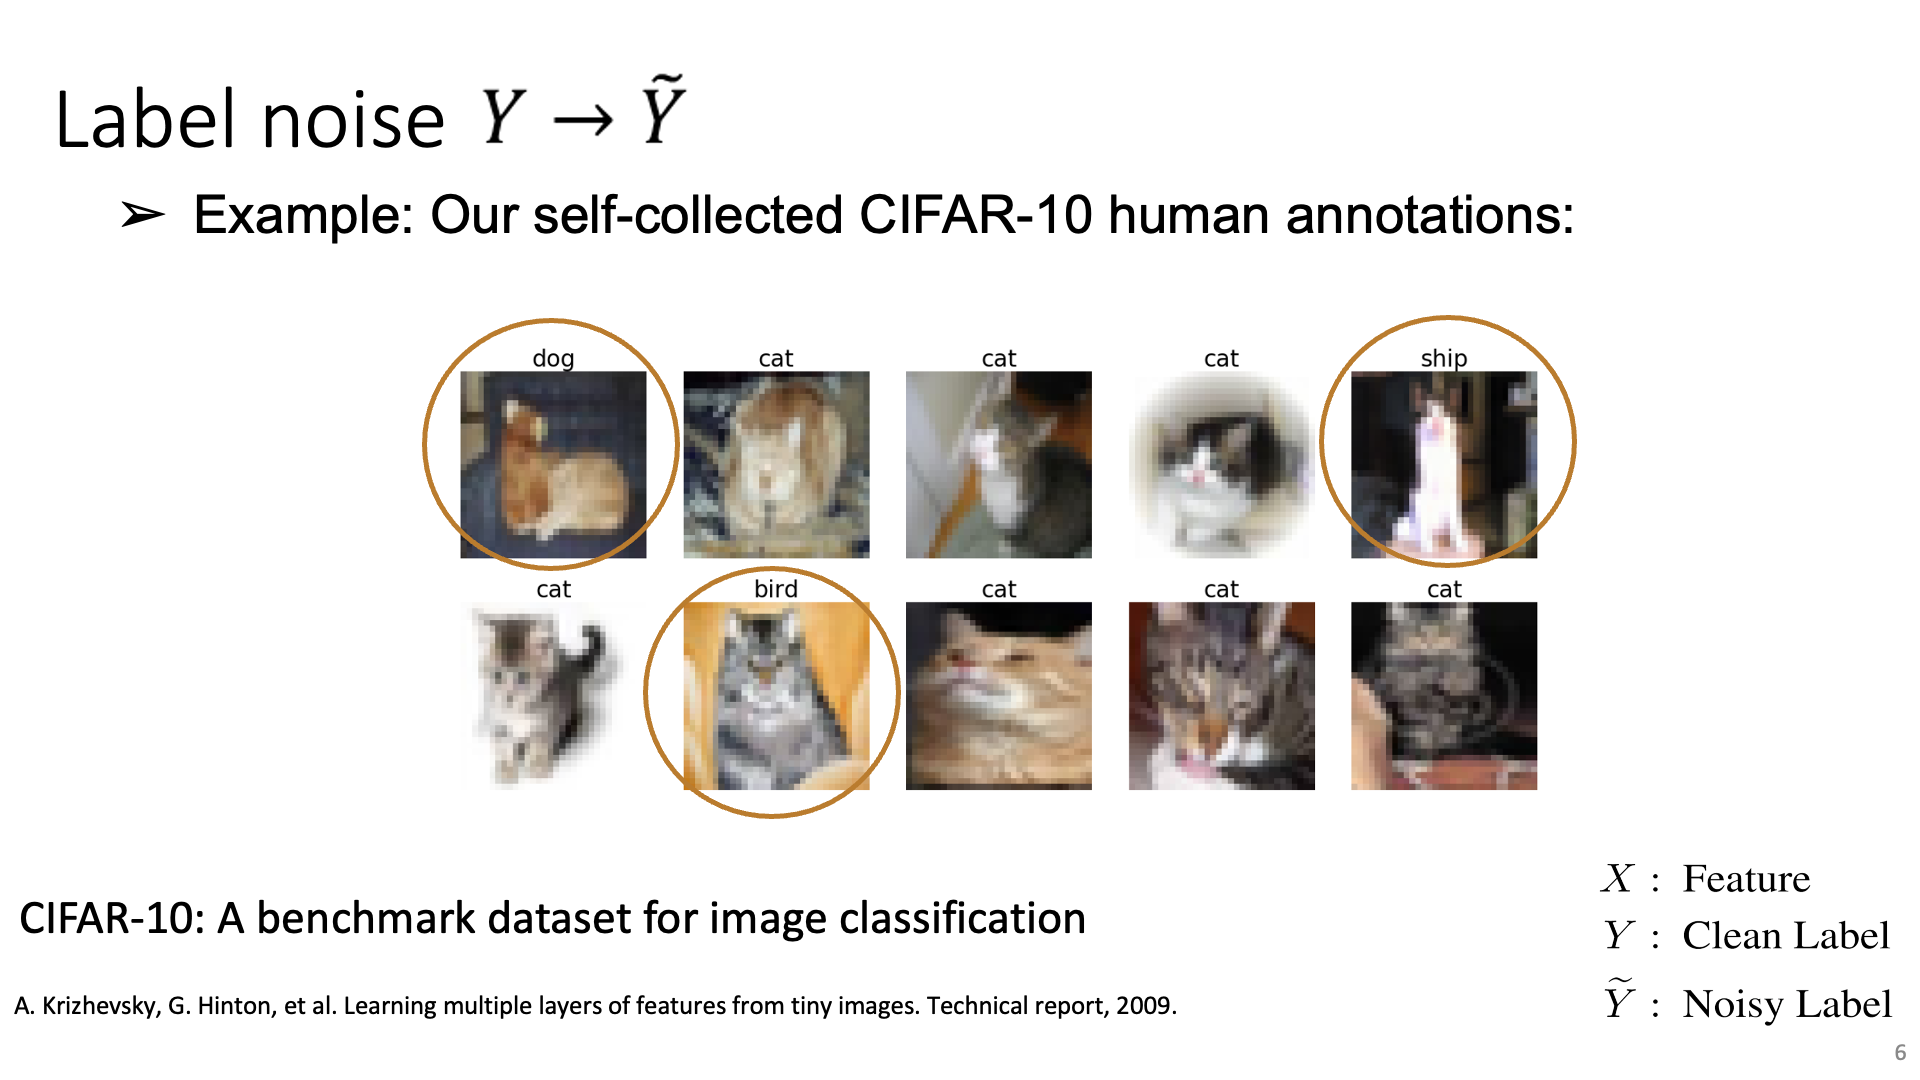

In [1]:
from IPython.display import Image
display(Image(filename='tutorial_imgs/label_noise.png', width = 750, height = 400))

## 2. The noise transition matrix

Statistically, given an instance $X$, the random variable of noisy labels $\widetilde{Y}$ can be characterized by a noise transition matrix $T$, where each element $T_{i,j}$ represents the probability of flipping the clean label $Y=i$ to the noisy label $\widetilde{Y} = j$, i.e.,

\begin{equation}
T_{ij}(X)=\mathbb P(\widetilde{Y}=j|Y=i).
\end{equation}

### Class-dependent label noise

The class-dependent label noise model ([Natarajan et al., 2013](https://proceedings.neurips.cc/paper/5073-learning-with-noisy-labels.pdf); [Liu & Tao, 2015](https://arxiv.org/abs/1411.7718); [Patrini et al., 2017](https://openaccess.thecvf.com/content_cvpr_2017/papers/Patrini_Making_Deep_Neural_CVPR_2017_paper.pdf)) assumes that the label noise is conditionally independent of features $X$, i.e.,

\begin{equation}
\mathbf{P}(\widetilde{Y} = j| Y = i) =\mathbf{P}(\widetilde{Y} = j| X, Y = i), \forall i,j \in [K].
\end{equation}

The intuitions of the label-noise model are two folds:

* Capture random flipping errors

* Easy access to theoretical analysis

Remembering the previous illustration figure, we could derive a rough estimate that:

\begin{equation}
\mathbf{P}(\widetilde{Y} = \text{dog}| Y = \text{cat}) = 1/10 = 0.1
\end{equation}

\begin{equation}
\mathbf{P}(\widetilde{Y} = \text{cat}| Y = \text{cat}) = 7/10 = 0.7
\end{equation}

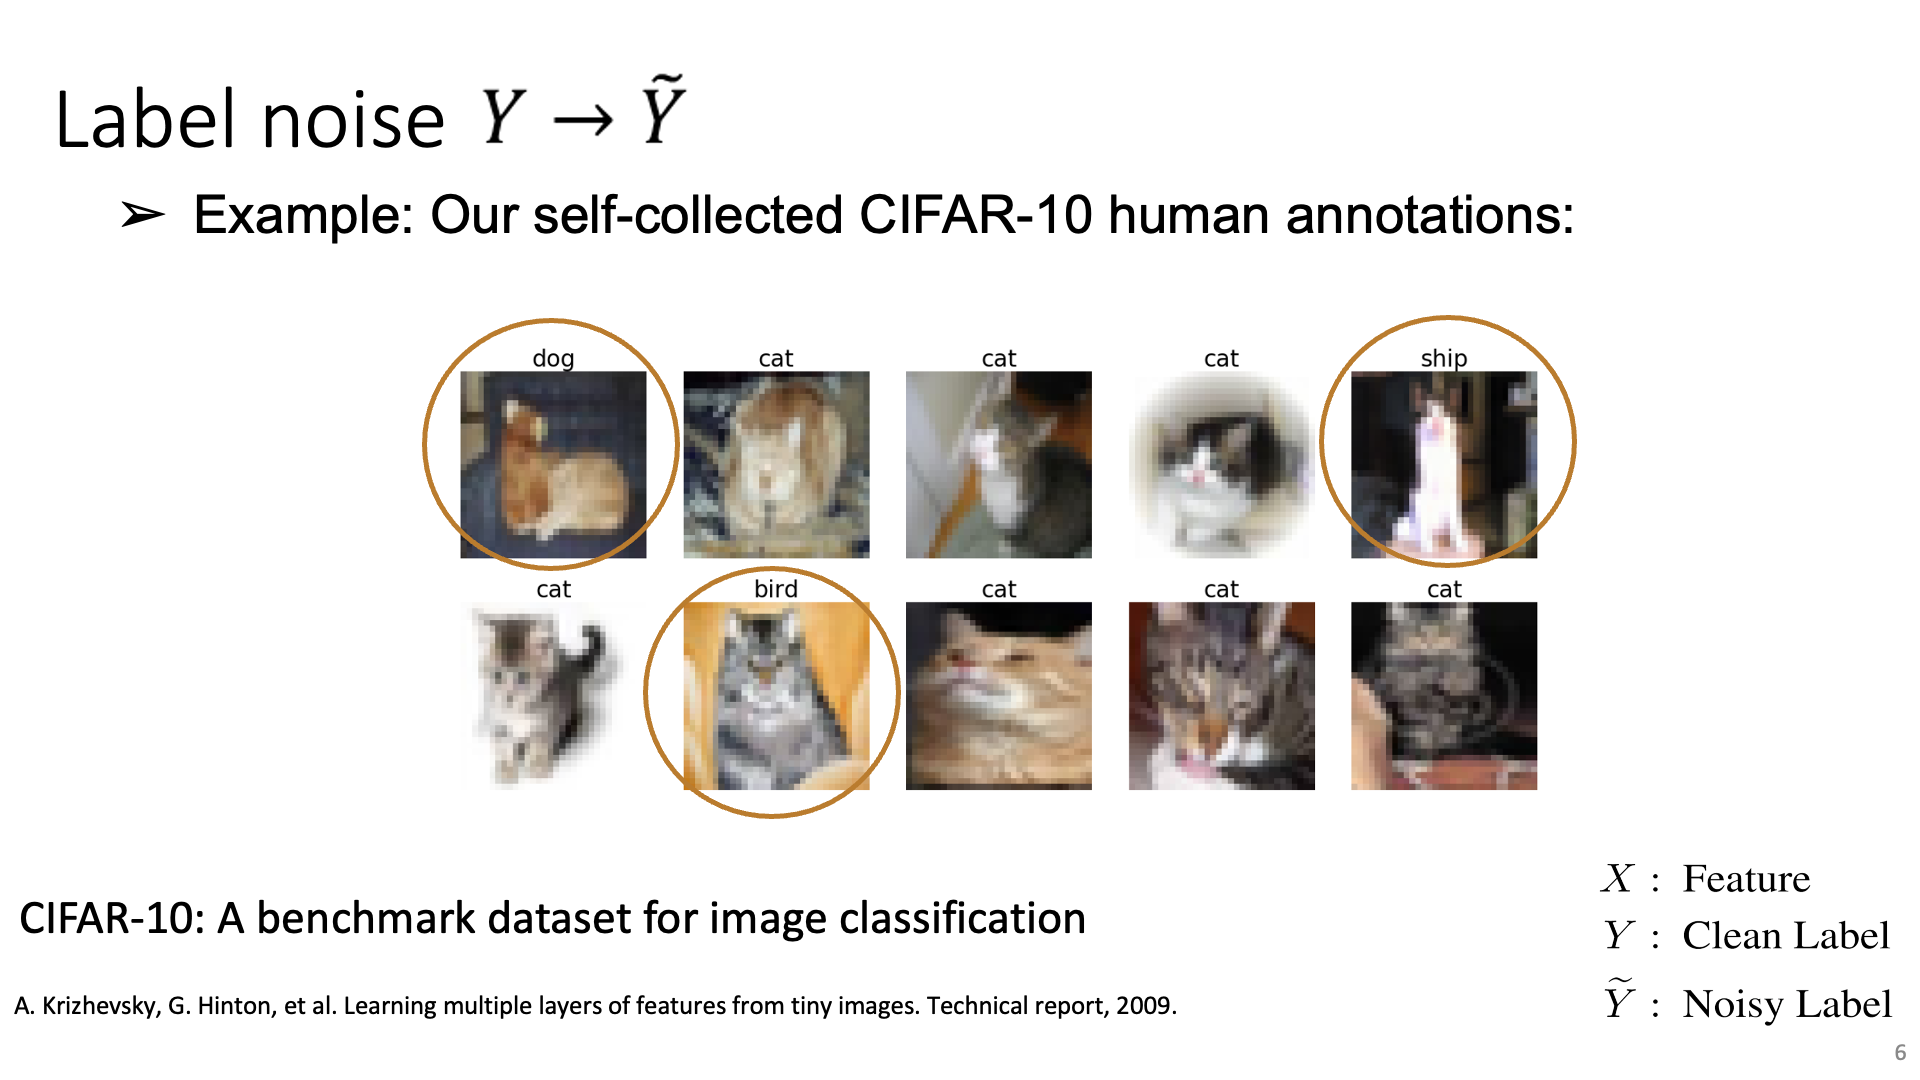

In [2]:
display(Image(filename='tutorial_imgs/label_noise.png', width = 750, height = 400))

### Popular models in class-dependent label noise

* **Symmetric noise** is generated by randomly flipping a true label to the other possible labels w.p. $\epsilon$ (Kim et al., 2019), where $\epsilon$ is called the noise rate.

* **Asymmetric noise (Pairflip)** is generated by flipping the true label to the next class (i.e., label $i \to i+1$, mod $K$) w.p. $\epsilon$, where $K$ is the number of classes.

### Simulation of class-dependent label noise

In [3]:
# basic function#
import numpy as np
from numpy.testing import assert_array_almost_equal
def multiclass_noisify(y, T, random_state=0):
    """ Flip classes according to transition probability matrix T.
    It expects a number between 0 and the number of classes - 1.
    """
    #print np.max(y), P.shape[0]
    assert T.shape[0] == T.shape[1]
    assert np.max(y) < T.shape[0]

    # row stochastic matrix
    assert_array_almost_equal(T.sum(axis=1), np.ones(T.shape[1]))
    assert (T >= 0.0).all()

    m = y.shape[0]
    #print m
    new_y = y.copy()
    flipper = np.random.RandomState(random_state)

    for idx in np.arange(m):
        i = y[idx]
        # draw a vector with only an 1
        flipped = flipper.multinomial(1, T[i, :][0], 1)[0]
        new_y[idx] = np.where(flipped == 1)[0]

    return new_y

### 3. Coding section

Load required libraries

In [4]:
import os
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.transforms as transforms
from data.cifar import CIFAR10
from data.datasets import input_dataset
from models import *
import argparse, sys
import numpy as np
import datetime
import shutil
from random import sample 
from loss import loss_gls
from torch.utils.data import RandomSampler

Parameter settings

In [5]:
args = {'noise_rate': 0.2, 'noise_type': 'symmetric', 'seed': 0, 'dataset': 'cifar10'}
# Noise type choices: pairflip, symmetric

In [6]:
torch.manual_seed(args['seed'])
# Hyper Parameters
batch_size = 128
n_type = args['noise_type']
# load dataset
train_dataset,test_dataset,num_classes,num_training_samples = input_dataset(args['dataset'],args['noise_type'],args['noise_rate'])


Actual noise 0.20
over all noise rate is  0.20076
Files already downloaded and verified


Take a look at the transition matrix $T$

In [19]:
def compute_matrix(y_clean, y_noisy):
    # Initialize 10*10 matrix with zeros
    wid = len(np.unique(train_dataset.train_labels))
    matrix = np.zeros((wid, wid))

    for i in range(len(y_clean)):
        # Increment the corresponding matrix cell by 1
        matrix[y_clean[i], y_noisy[i]] += 1
    
    # Sum each row and reshape the result for broadcasting division
    row_sums = matrix.sum(axis=1).reshape(-1, 1)
    
    # Avoid division by zero by replacing zero sums with 1
    row_sums[row_sums == 0] = 1

    normalized_matrix = np.round(matrix / row_sums, 3)
    return normalized_matrix
print(compute_matrix(train_dataset.train_labels, train_dataset.train_noisy_labels))

[[0.8   0.02  0.024 0.021 0.023 0.025 0.022 0.022 0.022 0.022]
 [0.022 0.799 0.023 0.021 0.023 0.023 0.02  0.023 0.021 0.025]
 [0.021 0.023 0.801 0.022 0.02  0.022 0.026 0.022 0.022 0.022]
 [0.023 0.025 0.023 0.795 0.024 0.021 0.02  0.021 0.025 0.023]
 [0.021 0.025 0.021 0.018 0.805 0.022 0.021 0.022 0.023 0.021]
 [0.02  0.023 0.029 0.025 0.023 0.789 0.021 0.023 0.027 0.02 ]
 [0.019 0.017 0.023 0.02  0.022 0.02  0.804 0.026 0.021 0.027]
 [0.021 0.024 0.019 0.022 0.022 0.023 0.024 0.8   0.025 0.019]
 [0.023 0.026 0.019 0.022 0.022 0.021 0.022 0.024 0.796 0.024]
 [0.02  0.022 0.023 0.025 0.022 0.021 0.02  0.019 0.022 0.805]]


Visualize some example images with clean and noisy labels

In [25]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
txt_classes = {0: 'airplane',
              1: 'automobile',
              2: 'bird',
              3: 'cat',
              4: 'deer',
              5: 'dog',
              6: 'frog',
              7: 'horse',
              8: 'ship',
              9: 'truck'}
    
def transform(img):
    npimg = img.numpy()
    print(np.transpose(npimg, (1, 2, 0)))
    return np.transpose(npimg, (1, 2, 0))
    # return npimg

def visualize(idxs, data):
    data_subset = torch.utils.data.Subset(data, idxs)
    plt.rcParams["figure.figsize"] = (9,7)
    for i in range(15):
        # print(dataset[i])
        X,y, _ = data_subset[i]
        ax = plt.subplot(3,5,i+1)
        ax.set_title(txt_classes[int(y)])
        ax.imshow(transform(X))
        ax.axis('off')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

[[[-1.440435   -1.8872501  -2.0653107 ]
  [-0.72319305 -1.4152457  -1.8116769 ]
  [-0.10287576 -0.8055735  -1.3824506 ]
  ...
  [-2.4290657  -2.4182549  -2.221393  ]
  [-2.4290657  -2.4182549  -2.221393  ]
  [-2.4290657  -2.4182549  -2.221393  ]]

 [[-0.82011765 -1.4349126  -1.7726563 ]
  [-0.29672492 -1.002242   -1.4214711 ]
  [ 0.07158863 -0.60890514 -1.1678373 ]
  ...
  [-2.4290657  -2.4182549  -2.221393  ]
  [-2.4290657  -2.4182549  -2.221393  ]
  [-2.4290657  -2.4182549  -2.221393  ]]

 [[-0.37426457 -1.1792437  -1.6751049 ]
  [-0.19980034 -1.0415757  -1.5775534 ]
  [-0.16103052 -0.96290827 -1.5385329 ]
  ...
  [-2.4290657  -2.4182549  -2.221393  ]
  [-2.4290657  -2.4182549  -2.221393  ]
  [-2.4290657  -2.4182549  -2.221393  ]]

 ...

 [[ 1.3316082   0.59077245 -1.7336358 ]
  [ 1.4091479   0.6891067  -1.5580431 ]
  [ 1.4673026   0.80710775 -1.5190226 ]
  ...
  [-2.4290657  -2.4182549  -2.221393  ]
  [-2.4290657  -2.4182549  -2.221393  ]
  [-2.4290657  -2.4182549  -2.221393  ]]

 [

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[-2.4290657  -2.4182549  -2.221393  ]
  [ 0.9439098   0.66943985  0.6466199 ]
  [ 1.0989891   0.8267746   0.8222125 ]
  ...
  [ 0.82760036  0.59077245  0.66613024]
  [ 0.6531361   0.4531046   0.5490685 ]
  [ 0.6531361   0.53177196  0.58808905]]

 [[-2.4290657  -2.4182549  -2.221393  ]
  [ 1.7580763   1.4364468   1.388011  ]
  [ 1.7580763   1.4561136   1.4270315 ]
  ...
  [ 0.5174417   0.2367693   0.2369037 ]
  [ 0.5174417   0.29576984  0.2954347 ]
  [ 0.32359254  0.19743562  0.15886253]]

 [[-2.4290657  -2.4182549  -2.221393  ]
  [ 2.2426991   1.8887842   1.797727  ]
  [ 2.2233143   1.908451    1.8757682 ]
  ...
  [ 1.3316082   1.0824436   0.9978052 ]
  [ 1.3122232   1.1021104   1.0173154 ]
  [ 1.2540685   1.0824436   0.9587846 ]]

 ...

 [[-2.4290657  -2.4182549  -2.221393  ]
  [-2.4290657  -2.4182549  -2.221393  ]
  [-2.4290657  -2.4182549  -2.221393  ]
  ...
  [-2.4290657  -2.4182549  -2.221393  ]
  [-2.4290657  -2.4182549  -2.221393  ]
  [-2.4290657  -2.4182549  -2.221393  ]]

 [

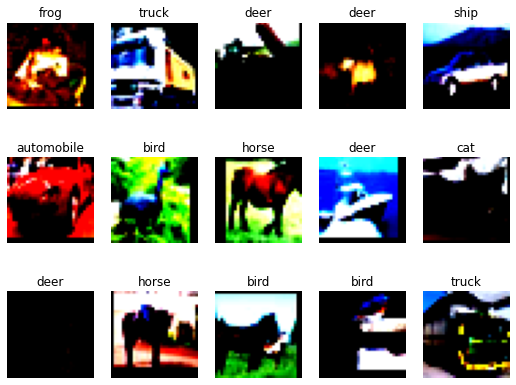

In [26]:
visualize(range(15), train_dataset)